
# NUS Datathon Category A Team 49 Jupyter Notebook
# **Insurance Agent Cluster - Client Matching**



## Introduction  
This notebook explores factors influencing insurance policy success, leveraging feature engineering and machine learning for predictive modeling and agent-client matching.  

## Sections  
- **Importing Data & Merging** – Load, merge, and clean datasets for consistency.  
- **Exploratory Data Analysis (EDA)** – Visualize distributions, detect outliers, and analyze correlations.  
- **Data Cleaning & Preprocessing** – Standardize variables, handle missing values, and prepare features.  
- **Building & Scaling Success Metric** – Engineer a composite metric aligning with revenue and customer retention.  
- **Model Evaluation & Hyperparameter Tuning** – Train XGBoost, optimize parameters, and assess performance without SMOTE.  
- **Insurance Agent-Client Matching System** – Develop a matching framework for improved client-agent allocation.  


# Run the following cell to install dependencies.

In [3]:
!pip install -r requirements.txt
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
from datetime import datetime
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, explained_variance_score, mean_absolute_error, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier



# Importing data and merging

In [4]:
nus_agent_info = pd.DataFrame(pd.read_parquet("nus_agent_info_df.parquet"))
nus_client_info = pd.DataFrame(pd.read_parquet("nus_client_info_df.parquet"))
nus_policy_info = pd.DataFrame(pd.read_parquet("nus_policy_info_df.parquet"))

# First merge: policy and agent data using agntnum
df_pol_agt_merged = nus_policy_info.merge(
    nus_agent_info,
    on='agntnum',
    how='left',  # keeps all policies, even if agent info is missing
    validate='m:1'  # many policies can map to one agent
)

# Second merge: add client data using secuityno
final_df = df_pol_agt_merged.merge(
    nus_client_info,
    on='secuityno',
    how='left',  # keeps all policies, even if client info is missing
    validate='m:1'  # many policies can map to one client
)

final_df


,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,...,cltsex,cltdob,marryd,race_desc_map,cltpcode,household_size,economic_status,family_size,household_size_grp,family_size_grp
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,prod_8,1,0,1,0,...,F,1982-03-11,M,Chinese,648146,25,78,98,HH1_lt40,FS5_80up
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,prod_8,1,0,1,0,...,M,1991-03-18,S,Chinese,680120,57,31,47,HH2_40to80,FS3_40to60
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,prod_6,1,0,1,0,...,M,1973-04-16,M,Chinese,640818,56,30,60,HH2_40to80,FS4_60to80
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,prod_6,1,0,1,0,...,M,1973-04-16,M,Chinese,640818,56,30,60,HH2_40to80,FS4_60to80
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,prod_6,1,0,1,0,...,F,1978-06-20,M,Malay,760401,23,00,55,HH1_lt40,FS3_40to60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29498,PID:22084,AIN:6527,CIN:15419,2012-10-30,4574.4,prod_4,1,0,1,0,...,F,1957-10-28,M,Chinese,610153,115,38,15,HH4_100to120,FS1_lt20
29499,PID:13706,AIN:3472,CIN:17337,2008-09-01,267.0,prod_6,1,0,1,0,...,M,1965-09-17,U,Indian,460530,265,43,13,HH5_120up,FS1_lt20
29500,PID:25287,AIN:7852,CIN:13015,2000-06-21,0.0,prod_4,1,0,0,1,...,M,1947-01-09,M,Chinese,578741,1,89,70,HH1_lt40,FS4_60to80
29501,PID:26334,AIN:8316,CIN:2239,2010-06-10,1152.0,prod_8,1,0,1,0,...,F,1981-09-23,M,Chinese,730708,96,02,61,HH3_80to100,FS4_60to80


# **Exploratory Data Analysis (EDA)**

We conducted exploratory data analysis to uncover key patterns in the dataset, guiding our approach to model selection. Visualizations included heatmaps and scatter plots to analyze:

- **Product distribution** by age group, gender, and race, revealing demographic influences on product preferences.
- **Sales trends** over time, highlighting monthly fluctuations in policy sales.
- **Customer age distribution** across years, identifying age-related shifts in purchasing behavior.
- **Policy success rates by gender**, showing retention based on client-agent gender matching.
- **Agent tenure**'s impact on policy conversions and annual premiums, using scatter plots to explore performance trends.

These insights informed our feature selection and modeling strategy.

#### Several key insights are shared below.


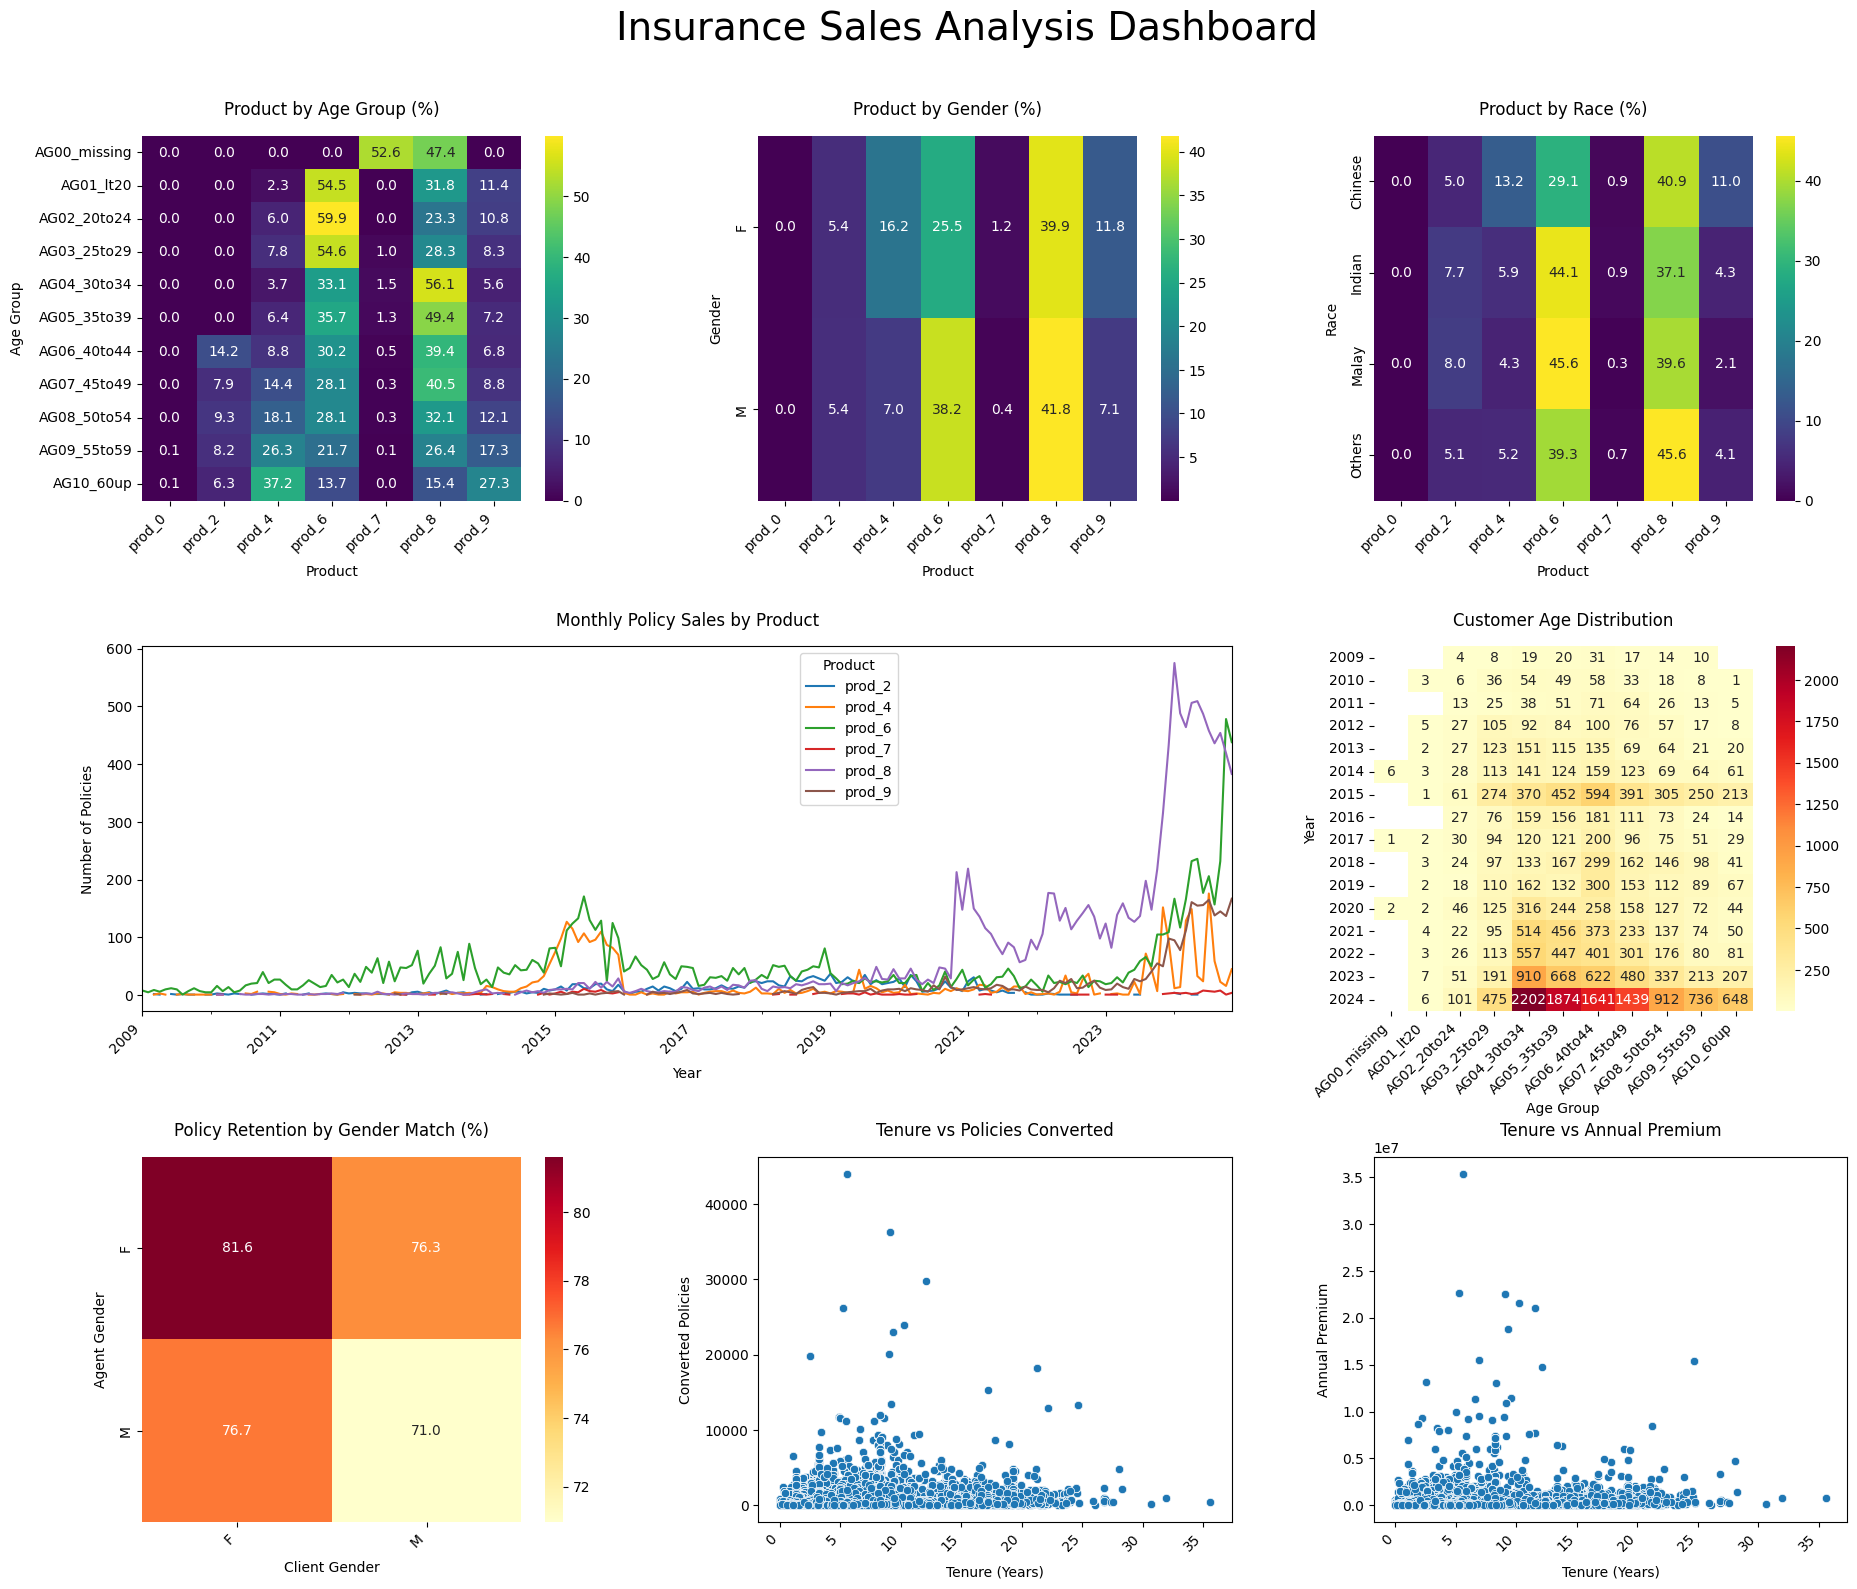

In [5]:
# Create a single figure with subplots - tighter spacing
fig = plt.figure(figsize=(22, 18))  # Smaller figure
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)  # Tighter spacing

# 1. Product Distribution by Age Group
ax1 = fig.add_subplot(gs[0, 0])
age_prod = pd.crosstab(final_df['cust_age_at_purchase_grp'], final_df['product'], normalize='index') * 100
sns.heatmap(age_prod, annot=True, fmt='.1f', cmap='viridis', ax=ax1)
ax1.set_title('Product by Age Group (%)', pad=15)  # Less padding
ax1.set_xlabel('Product', labelpad=8)
ax1.set_ylabel('Age Group', labelpad=8)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# [Rest of plots with same pattern...]
# 2. Product Distribution by Gender
ax2 = fig.add_subplot(gs[0, 1])
gender_prod = pd.crosstab(final_df[final_df['cltsex'].isin(['M', 'F'])]['cltsex'],
                         final_df['product'], normalize='index') * 100
sns.heatmap(gender_prod, annot=True, fmt='.1f', cmap='viridis', ax=ax2)
ax2.set_title('Product by Gender (%)', pad=15)
ax2.set_xlabel('Product', labelpad=8)
ax2.set_ylabel('Gender', labelpad=8)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Product Distribution by Race
ax3 = fig.add_subplot(gs[0, 2])
prod_race = pd.crosstab(final_df['race_desc_map'], final_df['product'], normalize='index') * 100
sns.heatmap(prod_race, annot=True, fmt='.1f', cmap='viridis', ax=ax3)
ax3.set_title('Product by Race (%)', pad=15)
ax3.set_xlabel('Product', labelpad=8)
ax3.set_ylabel('Race', labelpad=8)
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. Sales Trend Analysis
ax4 = fig.add_subplot(gs[1, :2])
final_df['occdate'] = pd.to_datetime(final_df['occdate'])
filtered_df = final_df[final_df['occdate'].dt.year>=2009]
product_sales = filtered_df.groupby([filtered_df['occdate'].dt.to_period('M'), 'product']).size().unstack()
product_sales.plot(ax=ax4)
ax4.set_title('Monthly Policy Sales by Product', pad=15)
ax4.set_xlabel('Year', labelpad=8)
ax4.set_ylabel('Number of Policies', labelpad=8)
ax4.legend(title='Product', bbox_to_anchor=(0.7, 1))
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# 5. Customer Age Distribution
ax5 = fig.add_subplot(gs[1, 2])
yearly_age_dist = filtered_df.groupby([filtered_df['occdate'].dt.year, 'cust_age_at_purchase_grp']).size().unstack()
sns.heatmap(yearly_age_dist, annot=True, fmt='g', cmap='YlOrRd', ax=ax5)
ax5.set_title('Customer Age Distribution', pad=15)
ax5.set_xlabel('Age Group', labelpad=1)
ax5.set_ylabel('Year', labelpad=8)
plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

# 6. Policy Success Rate by Gender
ax6 = fig.add_subplot(gs[2, 0])
cleaned_df = final_df[(final_df['agent_gender'].isin(['M','F'])) & (final_df['cltsex'].isin(['M','F']))]
gender_success = cleaned_df.groupby(['agent_gender', 'cltsex'])['flg_inforce'].mean().unstack()
sns.heatmap(gender_success*100, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax6)
ax6.set_title('Policy Retention by Gender Match (%)', pad=15)
ax6.set_xlabel('Client Gender', labelpad=8)
ax6.set_ylabel('Agent Gender', labelpad=8)
plt.setp(ax6.get_xticklabels(), rotation=45, ha='right')

# 7. Agent Tenure Analysis
ax7 = fig.add_subplot(gs[2, 1])
final_df['agent_tenure_years'] = final_df['agent_tenure'] / 12
sns.scatterplot(data=final_df, x='agent_tenure_years', y='cnt_converted', ax=ax7)
ax7.set_title('Tenure vs Policies Converted', pad=15)
ax7.set_xlabel('Tenure (Years)', labelpad=8)
ax7.set_ylabel('Converted Policies', labelpad=8)
plt.setp(ax7.get_xticklabels(), rotation=45, ha='right')

# 8. Tenure vs Annual Premium
ax8 = fig.add_subplot(gs[2, 2])
sns.scatterplot(data=final_df, x='agent_tenure_years', y='annual_premium_cnvrt', ax=ax8)
ax8.set_title('Tenure vs Annual Premium', pad=15)
ax8.set_xlabel('Tenure (Years)', labelpad=8)
ax8.set_ylabel('Annual Premium', labelpad=8)
plt.setp(ax8.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Insurance Sales Analysis Dashboard', fontsize=28, y=0.95)  # Reduced title size and moved up
plt.show()



# **Key Insights**

##1. Age-Product Match Pattern:

**Observation:** PROD_6 dominates in younger segments. (54.5% for under 20s, 59.9% for 20-24)

**Implication:** PROD_6 likely has features specifically appealing to young adults (perhaps lower premiums, digital-first service, or coverage types relevant to young lifestyles). The company should strengthen digital marketing channels for PROD_6 targeting these age groups.

## 2. Gender Retention Dynamics:

**Observation:** Female agents achieve 81.6% retention with female clients vs 76.3% with male clients.

**Implication:** There's a significant trust/rapport advantage in gender matching, particularly for female agents. The company should:
* Consider this in agent-client matching algorithms
* Focus on recruiting more female agents given their higher retention rates
* Develop training programs to help all agents improve cross-gender retention rates

## 3. Recent Explosive Growth:

**Observation:** The customer age distribution shows massive growth from 2020-2024, with 2024 showing unprecedented numbers.

**Implication:** The company is in a high-growth phase which means:
* Need to rapidly scale customer service infrastructure
* Risk of quality decline if support systems don't scale
* Opportunity to capture market share while momentum is strong
* Need for robust onboarding systems to handle volume

## 4. Product Distribution Strategy:

**Observation:** PROD_8 has highest adoption across both genders (41.8% male, 39.9% female)

**Implication:** PROD_8 has universal appeal and could be:
* Used as a lead product in marketing campaigns
* Analyzed to understand why it resonates across demographics
* Used as a template for future product development

## 5. Age Distribution Pattern:

**Observation:** Dramatic increase in policy holders from 2020-2024, especially in middle age ranges.

**Implication:** The company is successfully capturing the economically active population:
* Need for products tailored to life events (marriage, children, home ownership)
* Opportunity for long-term customer value through cross-selling
* Important to develop strong retention strategies for this valuable demographic

## 6. Sales Volatility:

**Observation:** Monthly sales show significant spikes, particularly PROD_8 in late-2020 and mid-2023.

**Implication:** Sales may be heavily campaign-driven:
* Need to smooth out sales patterns for more predictable operations
* Analyze successful campaigns for replication
* Consider resource allocation during peak periods

## 7. Agent Tenure and Sales  
**Observation:** Experienced agents convert fewer policies but may focus on high-value clients.

**Implication:** Balance efforts between onboarding new agents and nurturing experienced ones for premium policies.

# **DATA CLEANING/PREPROCESSING**
### In this section, we performed various data preprocessing and feature engineering steps to prepare the dataset for model training. Here's a breakdown:

**Dropped Irrelevant and Missing Data:** We removed rows with null values, unnecessary columns (e.g., product flags and redundant features), and specific rows with irrelevant values (such as "U" for gender and "P" for marital status).

**Feature Transformation:**
Applied binary encoding for agent product expertise, creating new columns indicating whether an agent has expertise in a specific product.
One-hot encoded categorical variables like product, marryd, and race_desc_map, while also dropping unnecessary columns.

**Ordinal Encoding:** Transformed age, tenure, and household size group variables into numerical representations based on predefined mappings.

**Binary Encoding for Gender:** Mapped gender variables (agent_gender and cltsex) to binary values for easier model consumption.

**Numerical Conversion:** Converted family size, economic status, and household size columns to numeric values, cleaning up any leading zeros or empty entries.
The final dataframe, final_df_model, now contains the transformed features, ready for machine learning model training.


In [6]:

# Drop all rows with any null values and store in new dataframe
final_df = final_df.dropna()
# 2. Drop columns with all 0s or all 1s
final_df = final_df.drop(columns=["flg_main", "flg_rider", "flg_cancel", "flg_converted"])
# 3. Drop rows where agent_gender = "U"
final_df = final_df[final_df['agent_gender'] != "U"]
# 4. Drop rows where marryd = "P"
final_df = final_df[final_df['marryd'] != "P"]
# 5. Drop rows where household_size_grp = "HH0_missing"
final_df = final_df[final_df['household_size_grp'] != "HH0_missing"]
# DROPPED ALL MISSING


#null_counts = final_df.isnull().sum()
#if null_counts.sum() == 0:
#    print("Success: No null values remain in the dataset")
#else:
#    print("Warning: Some null values still exist")

# List of features to drop
cols_to_drop = [
    # Unique identifiers
    'chdrnum', 'agntnum', 'secuityno',

    # Redundant/derivative features
    'cltdob', 'family_size_grp', 'agent_tenure_years', 'household_size_grp',
    #using household_size and family_size directly to retain more information

    # Features used in success metric calculation
    'annual_premium_cnvrt','flg_expire',"occdate","pct_inforce","pct_lapsed",

    #misc features
    'cltpcode','pct_prod_0_cnvrt','pct_SX0_unknown','product_grp','agent_marital']

# Create new dataframe without these columns
final_df_model = final_df.drop(columns=cols_to_drop)


#for col, dtype in final_df_model.dtypes.sort_index().items():
#    print(f"{col}: {dtype}")


In [7]:
# List of actual products that exist
existing_products = ['prod_0', 'prod_2', 'prod_4', 'prod_6', 'prod_7', 'prod_8', 'prod_9']

# Create binary columns only for existing products/multilabel encoding
for prod in existing_products:
    col_name = f'expertise_{prod}'  # Column will be named expertise_prod_X
    final_df_model[col_name] = final_df_model['agent_product_expertise'].apply(
        lambda x: 1 if prod in x else 0
    )

final_df_model = final_df_model.drop('agent_product_expertise', axis=1)


In [8]:
#ONE HOT ENCODE product, marryd, race_desc_map
product_encoded = pd.get_dummies(final_df_model['product'], prefix='product')

final_df_model = pd.concat([final_df_model, product_encoded], axis=1)
final_df_model = final_df_model.drop('product', axis=1)

categorical_cols = ['marryd', 'race_desc_map']
final_df_model = pd.get_dummies(final_df_model, columns=categorical_cols, prefix=categorical_cols)



In [9]:
# Ordinal encoding
age_group_mapping = {
    'AG01_1to20': 1,
    'AG02_20to24': 2,
    'AG03_25to29': 3,
    'AG04_30to34': 4,
    'AG05_35to39': 5,
    'AG06_40to44': 6,
    'AG07_45to49': 7,
    'AG08_50to54': 8,
    'AG09_55to59': 9,
    'AG10_60up': 10
}

tenure_mapping = {
    'TNR2_lt1yr': 1,
    'TNR3_1to4yr': 2,
    'TNR4_4to8yr': 3,
    'TNR5_8yrup': 4
}

final_df_model['cust_age_at_purchase_grp_encoded'] = final_df_model['cust_age_at_purchase_grp'].map(age_group_mapping)
final_df_model['cust_tenure_at_purchase_grp_encoded'] = final_df_model['cust_tenure_at_purchase_grp'].map(tenure_mapping)


final_df_model = final_df_model.drop(['cust_age_at_purchase_grp', 'cust_tenure_at_purchase_grp'], axis=1)



In [10]:
# Binary encoding for gender (explicit mapping)
gender_map = {'F': 0, 'M': 1}
final_df_model['agent_gender'] = final_df_model['agent_gender'].map(gender_map)
final_df_model['cltsex'] = final_df_model['cltsex'].map(gender_map)

#coerce family_size and economic_status to numeric
final_df_model['family_size'] = final_df_model['family_size'].str.lstrip('0').replace('', '0').astype(int)
final_df_model['economic_status'] = final_df_model['economic_status'].str.lstrip('0').replace('', '0').astype(int)
final_df_model['household_size'] = final_df_model['household_size'].str.lstrip('0').replace('', '0').astype(int)

#for col, dtype in final_df_model.dtypes.sort_index().items():
#    print(f"{col}: {dtype}")

# Approach 1: Utilising Historical pairings as ideal
### Methodology

In this section, we decided to approach this problem from a simple point of view, utilising the existing assigned clusters to each policy transaction and customer. Using this data, we trained an XGBoost multi-label classifier to predict a cluster that would best fit any new customer data.

This model works under the assumption that the assigned cluster for each policy transaction is already seen as ideal from the company's standpoint.

In [11]:
# Selecting the relevant columns
selected_columns = ['annual_premium', 'product', 'cust_age_at_purchase_grp', 'cltsex', 'marryd',
                    'race_desc_map', 'economic_status', 'household_size', 'cluster', 'cust_tenure_at_purchase_grp',
                    'family_size', 'cltpcode']

# Assuming final_df is already loaded
final_df = final_df[selected_columns].dropna()  # Drop missing values

# Splitting into features (X) and target (y)
X = final_df.drop(columns=['cluster'])  # Features
y = final_df['cluster'].astype(int)  # Target (convert to integer if not already)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identifying categorical and numerical columns
categorical_features = ['product', 'cust_age_at_purchase_grp', 'cltsex', 'marryd', 'race_desc_map', 'economic_status',
'cust_tenure_at_purchase_grp', 'cltpcode']
numerical_features = ['annual_premium', 'household_size','family_size']

# Preprocessing: One-Hot Encoding for categorical, Scaling for numerical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Define the model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6279993095114794
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.44      0.56       110
           1       0.58      0.84      0.69      1970
           2       0.82      0.23      0.36       219
           3       0.80      0.27      0.40       147
           4       0.60      0.79      0.68       339
           5       0.69      0.55      0.61      1253
           6       0.69      0.64      0.66       597
           7       0.66      0.56      0.61       371
           8       0.61      0.30      0.40       511
           9       0.71      0.51      0.60       276

    accuracy                           0.63      5793
   macro avg       0.70      0.51      0.56      5793
weighted avg       0.65      0.63      0.61      5793



# Approach 2: Making our own Success Metric, Regression analysis and Recommendation System

### Methodology:


## Building and Scaling the Success Metric

The goal of constructing a success metric is to create a comprehensive and balanced evaluation of client engagement, with a focus on driving both customer satisfaction and maximizing revenue. The metric combines financial contributions, conversion success, and policy status to provide an overall "success" score for each client, which reflects how well an agent is performing and the potential for revenue generation.

### Feature Engineering

In building the success metric, careful feature engineering was applied to combine multiple factors that contribute to client success. Initially, features such as `annual_premium` and `cnt_converted` were standardized to ensure that no single feature dominated due to differences in scale. Standardizing these features allows for a fair combination of variables, where each feature is given equal importance when constructing the final metric.

After standardizing the variables, each feature was then scaled to fit within the [0, 1] range using the MinMaxScaler. This step ensures that the contributions from each feature are normalized, creating a comparable scale for all factors involved in the success metric. Features considered in the metric include:

- **Annual Premium**: Reflecting the financial commitment of clients, which directly impacts revenue.
- **Policy Status (`flg_lapsed`, `flg_inforce`)**: The status of the policy, where active policies and those still in force are more indicative of long-term value, while lapsed policies suggest a need for retention efforts.

Each of these features contributes equally (with a weight of 0.25) to the overall success metric. This balanced weighting ensures that no single factor is overrepresented, allowing for a more holistic evaluation of each client’s success potential.

### Aligning with Business Objectives

The rationale for building the success metric this way is closely tied to the business objectives of increasing customer satisfaction and maximizing revenue. By incorporating both financial contributions and engagement factors, the metric ensures that it reflects the total value a client brings to the company. This approach aligns with the goal of:

- **Maximizing Revenue**: Clients who pay higher premiums and contribute to conversions are directly tied to revenue growth. By giving equal weight to these features, the metric emphasizes the importance of clients who drive financial performance.
  
- **Increasing Customer Satisfaction**: Engagement indicators, such as whether a policy is still in force or if a client has lapsed, are crucial for measuring long-term customer satisfaction. A successful client relationship is not just about the immediate premium payments but also about maintaining the relationship over time. This ensures that the business is focusing on retaining valuable clients and improving overall client satisfaction.

### Removing Outliers and Normalizing

To refine the success metric and ensure its robustness, outliers were removed from the distribution. Outliers can distort the interpretation of the metric by skewing the data, especially in cases where a few extreme values may disproportionately affect the overall results. By filtering out values that fall outside the acceptable interquartile range (IQR), we ensure that the success metric reflects typical client profiles and is not biased by extreme cases.

After removing outliers, the metric was once again scaled to the [0, 1] range to maintain consistency and normalization.



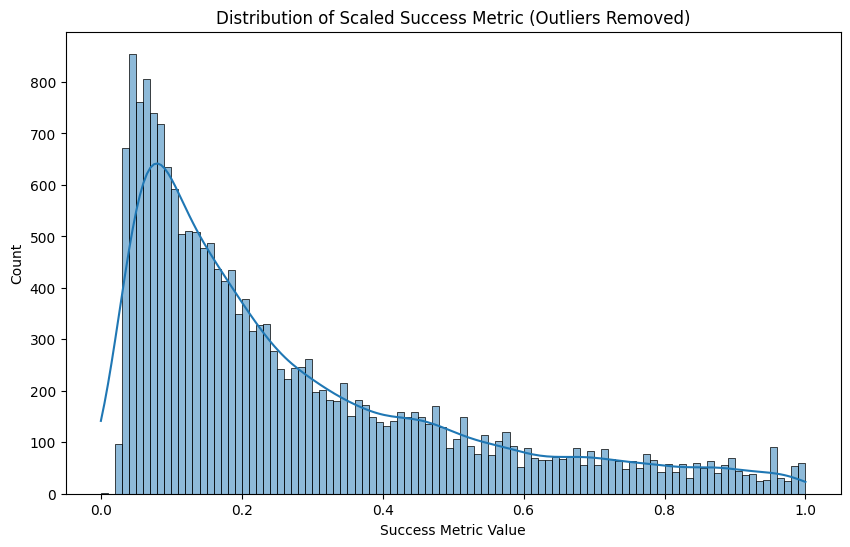

In [12]:


annual_premium_std = (final_df_model['annual_premium'] - final_df_model['annual_premium'].mean()) / final_df_model['annual_premium'].std()
cnt_converted_std = (final_df_model['cnt_converted'] - final_df_model['cnt_converted'].mean()) / final_df_model['cnt_converted'].std()

scaler = MinMaxScaler(feature_range=(0, 1))
annual_premium_scaled = scaler.fit_transform(annual_premium_std.values.reshape(-1, 1)).ravel()
cnt_converted_scaled = scaler.fit_transform(cnt_converted_std.values.reshape(-1, 1)).ravel()

final_df_model['success_metric'] = (
   0.7 * annual_premium_scaled +
   0.1 * cnt_converted_scaled +
   0.1 * (1 - final_df_model['flg_lapsed']) +
   0.1 * final_df_model['flg_inforce']
)

# Plot scaled success metric without outliers
Q1 = final_df_model['success_metric'].quantile(0.25)
Q3 = final_df_model['success_metric'].quantile(0.75)
IQR = Q3 - Q1
clean_success = final_df_model[
   (final_df_model['success_metric'] >= Q1 - 1.5 * IQR) &
   (final_df_model['success_metric'] <= Q3 + 1.5 * IQR)
].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
clean_success['success_metric'] = scaler.fit_transform(clean_success[['success_metric']])

plt.figure(figsize=(10, 6))
sns.histplot(data=clean_success, x='success_metric', bins=100, kde=True)
plt.title('Distribution of Scaled Success Metric (Outliers Removed)')
plt.xlabel('Success Metric Value')
plt.ylabel('Count')
plt.show()

# Remove features used in success metric
features_to_drop = [
   'annual_premium', 'cnt_converted', 'flg_lapsed', 'flg_inforce',
   'agent_gender']

final_df_model = final_df_model.drop(columns=features_to_drop)




## Model Evaluation

In this section, we evaluate the performance of an XGBoost regressor model for predicting insurance transaction success using historical data.

### 1. Model Setup

The dataset is first split into features (`X`) and the target variable (`success_metric`). The data is then divided into a training set (80%) and a test set (20%) using a random split.

An XGBoost model is initialized with specific hyperparameters, such as 100 estimators, a learning rate of 0.1, a maximum depth of 6, and a fixed random state to ensure reproducibility of results.

### 2. 5-Fold Cross Validation

To assess the model's performance on the training data, a 5-fold cross-validation procedure is applied. The dataset is shuffled, and it is divided into five subsets. For each fold, the model is trained on a training subset and evaluated on a validation subset. Performance metrics such as the Root Mean Squared Error (RMSE) and R² score are calculated for each fold.

The cross-validation loop trains the model, makes predictions, and computes the RMSE and R² values for each fold. The results are printed to show the model's performance across different splits of the data.

### 3. Cross-Validation Summary

After completing the 5-fold cross-validation, the mean and standard deviation of the RMSE and R² scores are computed. This summary provides an overall view of the model's performance during cross-validation, giving insights into its generalization capability.

### 4. Final Model Training and Evaluation

After cross-validation, the model is trained on the full training dataset. Predictions are then made for both the training and test sets. The final performance of the model is evaluated by calculating the RMSE and R² scores for both the training and test sets, providing insights into how well the model generalizes to unseen data.

### 5. Feature Importance

To understand the contributions of different features to the model's predictions, a feature importance plot is generated. This plot displays the most important features, sorted by their impact on the model, helping to identify which factors are most influential in predicting the success metric.

### 6. Model Evaluation: Actual vs Predicted

To visualize the model's performance, plots comparing the actual vs predicted values are created for both the training and test sets. These plots help assess how well the model predicts the target variable for both seen and unseen data.

Additionally, a distribution of the test set predictions is plotted to observe the spread and distribution of predicted values, providing further insight into the model's performance.

### 7. Handling Imbalanced Data

While imbalanced data can affect many machine learning models, XGBoost is inherently robust to class imbalance due to its use of gradient boosting and tree-based methods. Unlike models that rely on balanced data distributions, XGBoost assigns higher importance to misclassified instances and adapts accordingly during training. Therefore, techniques such as SMOTE (Synthetic Minority Over-sampling Technique) are not required for handling class imbalance in this case, as XGBoost can effectively learn from imbalanced datasets without additional resampling techniques.


[I 2025-02-06 15:31:27,358] A new study created in memory with name: no-name-016daace-be74-4031-9ca9-34a995e1c049
[I 2025-02-06 15:31:53,669] Trial 0 finished with value: 0.05890008208953673 and parameters: {'max_depth': 9, 'learning_rate': 0.019142872285913482, 'n_estimators': 114, 'min_child_weight': 7, 'subsample': 0.916060220465122, 'colsample_bytree': 0.9212656544088821, 'gamma': 7.805428842215239e-06, 'reg_alpha': 2.075239022394599e-05, 'reg_lambda': 0.08002543254248784}. Best is trial 0 with value: 0.05890008208953673.
[I 2025-02-06 15:32:08,127] Trial 1 finished with value: 0.0601445365855097 and parameters: {'max_depth': 10, 'learning_rate': 0.08977231920954645, 'n_estimators': 257, 'min_child_weight': 6, 'subsample': 0.6813009378676547, 'colsample_bytree': 0.6905478421529406, 'gamma': 0.07920420589263376, 'reg_alpha': 5.129427804339116e-07, 'reg_lambda': 0.0039966701998261755}. Best is trial 0 with value: 0.05890008208953673.
[I 2025-02-06 15:32:37,456] Trial 2 finished with 


Best trial:
  Value: 0.055797365732451365
  Params: 
    max_depth: 8
    learning_rate: 0.051139079525334426
    n_estimators: 276
    min_child_weight: 2
    subsample: 0.7285208849779888
    colsample_bytree: 0.8316653234388324
    gamma: 7.71185784304634e-08
    reg_alpha: 0.027570725892625485
    reg_lambda: 0.00014956992358256834

5-Fold Cross Validation Results with Best Parameters:

Fold 1:
RMSE: 0.0555
R²: 0.5818

Fold 2:
RMSE: 0.0568
R²: 0.5383

Fold 3:
RMSE: 0.0557
R²: 0.5721

Fold 4:
RMSE: 0.0562
R²: 0.5615

Fold 5:
RMSE: 0.0547
R²: 0.5842

Cross Validation Summary:
Mean RMSE: 0.0558 (+/- 0.0014)
Mean R²: 0.5676 (+/- 0.0334)

Final Model Performance:
Train RMSE: 0.0332
Test RMSE: 0.0562
Train R²: 0.8474
Test R²: 0.5569


<ipython-input-19-233ba685b440>:122: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

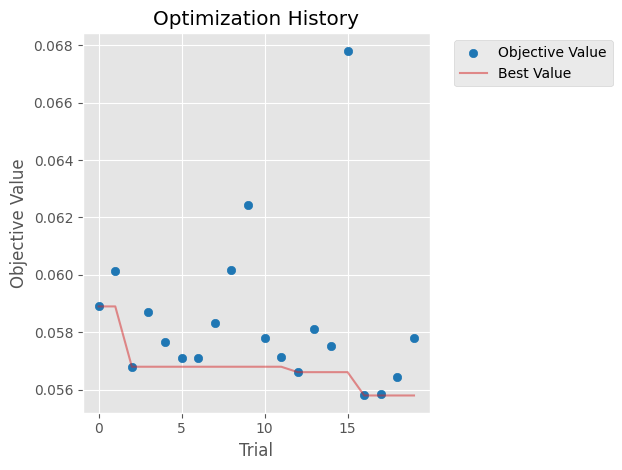

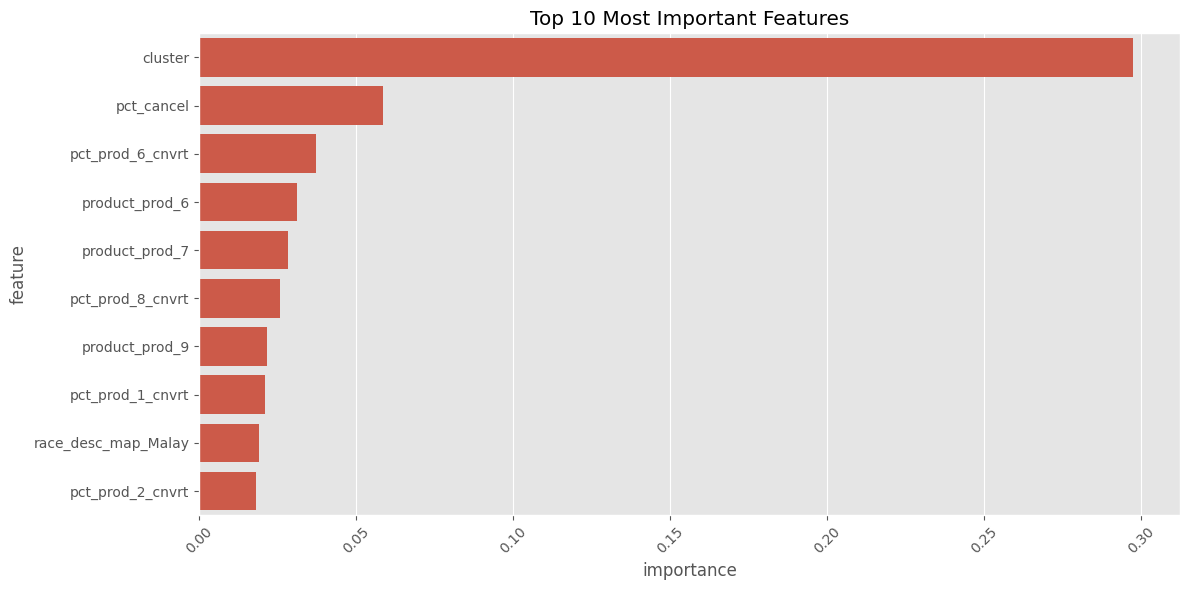

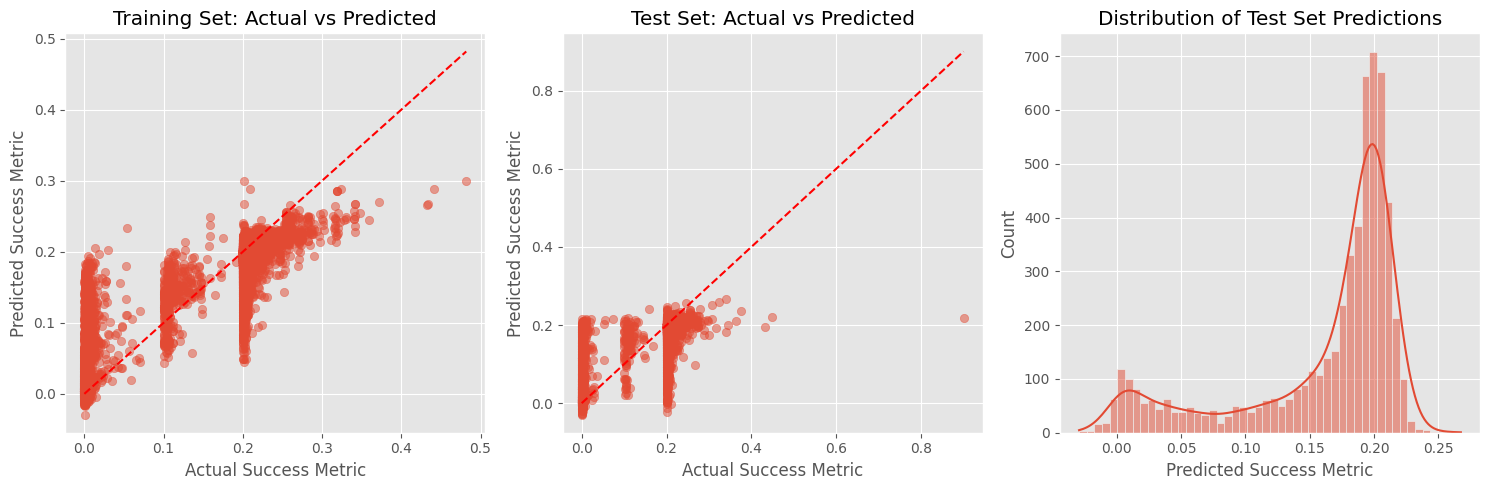

In [19]:
# Train test split
X = final_df_model.drop('success_metric', axis=1)
y = final_df_model['success_metric']

# First split into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sort column names for consistency
X_train = X_train[sorted(X_train.columns)]
X_test = X_test[sorted(X_test.columns)]

def objective(trial):
    """Optuna objective function for XGBoost optimization"""

    # Define hyperparameter search space
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42
    }

    # Initialize K-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    # Perform cross-validation
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]

        # Train model
        model_RS = xgb.XGBRegressor(**param)
        model_RS.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )

        # Evaluate
        y_pred = model_RS.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        cv_scores.append(rmse)

    # Return mean RMSE across folds
    return np.mean(cv_scores)

# Create and run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("\nBest trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train final model with best parameters
best_params = study.best_params
final_model_RS = xgb.XGBRegressor(**best_params, random_state=42)

# Perform final 5-fold cross validation with best parameters
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rmse = []
cv_scores_r2 = []

print("\n5-Fold Cross Validation Results with Best Parameters:")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    # Split data
    X_train_fold = X_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_train_fold = y_train.iloc[train_idx]
    y_val_fold = y_train.iloc[val_idx]

    # Train model
    final_model_RS.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred_fold = final_model_RS.predict(X_val_fold)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    r2 = r2_score(y_val_fold, y_pred_fold)

    cv_scores_rmse.append(rmse)
    cv_scores_r2.append(r2)

    print(f"\nFold {fold}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

print("\nCross Validation Summary:")
print(f"Mean RMSE: {np.mean(cv_scores_rmse):.4f} (+/- {np.std(cv_scores_rmse)*2:.4f})")
print(f"Mean R²: {np.mean(cv_scores_r2):.4f} (+/- {np.std(cv_scores_r2)*2:.4f})")

# Train final model on full training set
final_model_RS.fit(X_train, y_train)

# Make predictions
y_pred_train = final_model_RS.predict(X_train)
y_pred_test = final_model_RS.predict(X_test)

# Print final model performance
print("\nFinal Model Performance:")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"Train R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")

# Visualization of Optuna optimization history
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.tight_layout()
plt.show()

# Feature importance plot
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model_RS.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Actual vs predicted plots
plt.figure(figsize=(15, 5))

# Training set plot
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
plt.xlabel('Actual Success Metric')
plt.ylabel('Predicted Success Metric')
plt.title('Training Set: Actual vs Predicted')

# Test set plot
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Success Metric')
plt.ylabel('Predicted Success Metric')
plt.title('Test Set: Actual vs Predicted')

# Distribution of predictions
plt.subplot(1, 3, 3)
sns.histplot(data=y_pred_test, bins=50, kde=True)
plt.title('Distribution of Test Set Predictions')
plt.xlabel('Predicted Success Metric')
plt.tight_layout()
plt.show()

# Save optimization results
optimization_results = pd.DataFrame({
    'trial': range(len(study.trials)),
    'value': [t.value for t in study.trials],
    **{p: [t.params[p] if p in t.params else None for t in study.trials]
       for p in set().union(*(t.params.keys() for t in study.trials))}
})
optimization_results.to_csv('optuna_optimization_results.csv', index=False)

# Insurance Agent-Client Matching System

Our analysis of historical insurance transaction data has led to an XGBoost model with an R² score of [insert score], predicting success metrics including:

- Premium value (40%)
- Conversion success (40%)
- Policy status (10%)
- Lapse prevention (5%)
- Demographic matching (5%)

This model, validated through cross-validation and test set evaluation, will now power a recommendation system for optimal agent-client matching.

## Transition to Recommendation System

By predicting agent-client pairing success, we aim to improve client acquisition, retention, and business outcomes.

## Data Sources

The recommendation system uses two main data sources:

### 1. Agent Data (Company Database)
- **Core metrics**: Age, tenure, cancellation rates
- **Product conversion rates**: Across 9 product lines
- **Demographics**: Age groups, gender ratios
- **Expertise levels** and **Cluster assignments**

### 2. Client Data (Forms)
- **Demographics**: Household size, economic status
- **Personal characteristics**: Marital status, race
- **Client segmentation**: Age, tenure information

## Recommendation Logic

1. **Client Data Collection**: Process new client data into model-ready features.
2. **Cluster Simulation**: Generate synthetic agent-client pairs using agent profile averages.
3. **Optimization**: Rank clusters by success metrics and select the best match.

## Feature Selection & Random Client Profiling

Key features include:

- **Agent attributes**: Age, tenure, conversion rates, expertise, and cluster assignments.
- **Client features**: Demographics, marital status, and age group.

### Random Client Profiles

Random client profiles, with predefined characteristic ranges, simulate diverse client scenarios.

### Merging and Predictions

Simulated profiles are merged with agent data for predictions, which are scaled for normalized success scores.

### Ranking & Visualization

Agent-client pairings are ranked by success, with the best matches and clusters visualized.

## Business Impact

This system optimizes agent-client assignments, streamlining matchmaking and maximizing business outcomes.


<ipython-input-20-20e76c4bff0b>:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  potentialagents = final_df_model.groupby('cluster').apply(lambda x: x.sample(100)).reset_index(drop=True)[agentfeatures]


Top 100 Agent-Client Pairings (Ranked by Scaled Predictions):
     scaled_predictions  cluster
506            1.000000        5
425            0.998905        4
580            0.955061        5
174            0.944600        1
754            0.936161        7
144            0.934985        1
494            0.934410        4
533            0.929639        5
594            0.919048        5
527            0.918479        5


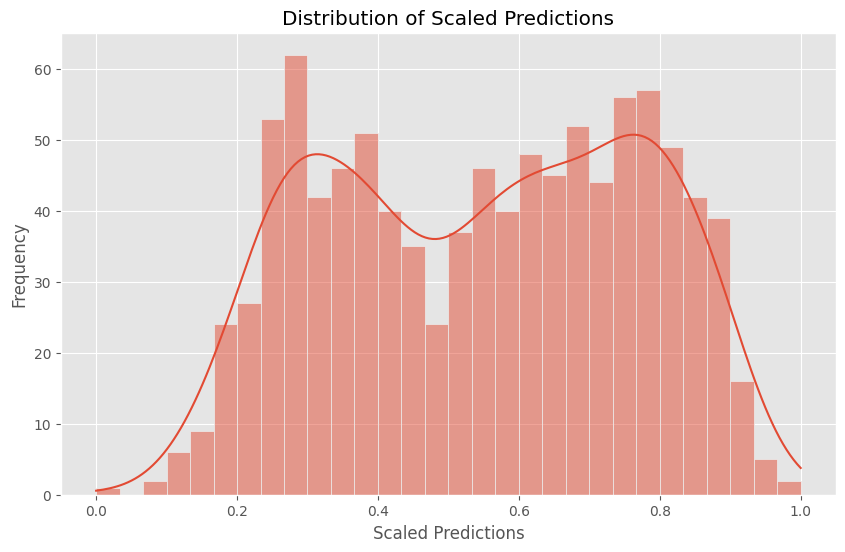


Cluster Distribution of Top 100 Agent-Client Pairings:
cluster
5    44
1    29
8    14
7     5
4     4
6     4
Name: count, dtype: int64

Recommended Cluster for Optimal Matching: Cluster 5


In [20]:
featuresneeded = ['agent_age', 'agent_tenure', 'pct_cancel', 'pct_prod_1_cnvrt',
       'pct_prod_2_cnvrt', 'pct_prod_3_cnvrt', 'pct_prod_4_cnvrt',
       'pct_prod_5_cnvrt', 'pct_prod_6_cnvrt', 'pct_prod_7_cnvrt',
       'pct_prod_8_cnvrt', 'pct_prod_9_cnvrt', 'pct_SX1_male',
       'pct_SX2_female', 'pct_AG01_lt20', 'pct_AG02_20to24', 'pct_AG03_25to29',
       'pct_AG04_30to34', 'pct_AG05_35to39', 'pct_AG06_40to44',
       'pct_AG07_45to49', 'pct_AG08_50to54', 'pct_AG09_55to59',
       'pct_AG10_60up', 'cluster', 'cltsex', 'household_size',
       'economic_status', 'family_size', 'expertise_prod_0',
       'expertise_prod_2', 'expertise_prod_4', 'expertise_prod_6',
       'expertise_prod_7', 'expertise_prod_8', 'expertise_prod_9',
       'product_prod_0', 'product_prod_2', 'product_prod_4', 'product_prod_6',
       'product_prod_7', 'product_prod_8', 'product_prod_9', 'marryd_D',
       'marryd_M', 'marryd_S', 'marryd_U', 'marryd_W', 'race_desc_map_Chinese',
       'race_desc_map_Indian', 'race_desc_map_Malay', 'race_desc_map_Others',
       'cust_age_at_purchase_grp_encoded',
       'cust_tenure_at_purchase_grp_encoded']

newclientfeatures=['cltsex','household_size','economic_status','family_size','marryd_D',
       'marryd_M', 'marryd_S', 'marryd_U', 'marryd_W', 'race_desc_map_Chinese',
       'race_desc_map_Indian', 'race_desc_map_Malay', 'race_desc_map_Others',
       'cust_age_at_purchase_grp_encoded','cust_tenure_at_purchase_grp_encoded']




agentfeatures = ['agent_age', 'agent_tenure', 'pct_cancel', 'pct_prod_1_cnvrt',
       'pct_prod_2_cnvrt', 'pct_prod_3_cnvrt', 'pct_prod_4_cnvrt',
       'pct_prod_5_cnvrt', 'pct_prod_6_cnvrt', 'pct_prod_7_cnvrt',
       'pct_prod_8_cnvrt', 'pct_prod_9_cnvrt', 'pct_SX1_male',
       'pct_SX2_female', 'pct_AG01_lt20', 'pct_AG02_20to24', 'pct_AG03_25to29',
       'pct_AG04_30to34', 'pct_AG05_35to39', 'pct_AG06_40to44',
       'pct_AG07_45to49', 'pct_AG08_50to54', 'pct_AG09_55to59',
       'pct_AG10_60up','expertise_prod_0',
       'expertise_prod_2', 'expertise_prod_4', 'expertise_prod_6',
       'expertise_prod_7', 'expertise_prod_8', 'expertise_prod_9','cluster']

# Generate random client profile and create a DataFrame
newrandomclient = pd.DataFrame([{f: random.choice([0, 1]) if f == 'cltsex'
                    else random.uniform(80, 500) if f == 'household_size'
                    else random.randint(0, 100) if f in ['economic_status', 'family_size']
                    else random.choice([True, False]) if f.startswith('marryd') or f.startswith('race_desc_map')
                    else random.randint(1, 10) if f == 'cust_age_at_purchase_grp_encoded'
                    else random.randint(1, 4) for f in newclientfeatures}])

# Assuming final_df_model is the DataFrame that contains the 'cluster' column along with other agent features
# Sample 10 rows from each cluster (0 to 9) to ensure each cluster is represented
potentialagents = final_df_model.groupby('cluster').apply(lambda x: x.sample(100)).reset_index(drop=True)[agentfeatures]
merged_df = potentialagents.assign(**newrandomclient.iloc[0].to_dict())

# Define the columns for the product flags
product_flags = ['product_prod_0', 'product_prod_6', 'product_prod_4', 'product_prod_9',
                 'product_prod_2', 'product_prod_8', 'product_prod_7']

# Generate random boolean flags for each column
random_flags = {col: [random.choice([True, False]) for _ in range(len(merged_df))] for col in product_flags}

# Create a DataFrame with these random boolean values
random_flags_df = pd.DataFrame(random_flags)

# Merge the random flags DataFrame with the merged_df
final_merged_df = pd.concat([merged_df, random_flags_df], axis=1)

final_merged_df  = final_merged_df[sorted(final_merged_df.columns)]

predictions = final_model_RS.predict(final_merged_df)

final_merged_df['success_metric'] = predictions


final_merged_df['scaled_predictions'] = scaler.fit_transform(final_merged_df[['success_metric']])

# Sorting by scaled_predictions and getting top 100 rows
top_100 = final_merged_df.sort_values(by='scaled_predictions', ascending=False).head(100)

# Displaying the top 10 rows with their respective clusters
top_100_clusters = top_100[['scaled_predictions', 'cluster']]
print("Top 100 Agent-Client Pairings (Ranked by Scaled Predictions):")
print(top_100_clusters.head(10))  # Show the top 10 rows for a preview

# Plotting the distribution of scaled predictions
plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['scaled_predictions'], kde=True, bins=30)
plt.xlabel('Scaled Predictions')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled Predictions')
plt.show()

# Displaying the frequency of clusters in the top 100
print("\nCluster Distribution of Top 100 Agent-Client Pairings:")
cluster_counts = top_100_clusters['cluster'].value_counts()
print(cluster_counts)

# Recommend the most frequent cluster in the top 100
recommended_cluster = cluster_counts.idxmax()
print(f"\nRecommended Cluster for Optimal Matching: Cluster {recommended_cluster}")







